# Link Prediction on MovieLens
Please run all the cells once. So that the code is already executed before you go through it.

We are using the MovieLens dataset collected by the GroupLens research group. This toy dataset describes ratings and tagging activity from MovieLens. The dataset contains approximately 100k ratings across more than 9k movies from more than 600 users. We use this dataset to generate two node types holding data for movies and users, respectively, and one edge type connecting users and movies, representing the relation of whether a user has rated a specific movie.

In [1]:
# Importing necessary modules

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch import Tensor

from torch_geometric.explain import CaptumExplainer, Explainer, Explanation
from torch_geometric.nn import SAGEConv, to_hetero
import torch_geometric.transforms as T

print(torch.__version__)

import os
os.environ['TORCH'] = torch.__version__

# Checking if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

2.0.1+cu118
cuda


## Heterogeneous Graph Creation

In [2]:
# Downloading the data set
from torch_geometric.data import download_url, extract_zip

url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, 'dataset'), 'dataset')

Extracting dataset\ml-latest-small.zip


In [3]:
# Creating Dataframe
movies_path = './dataset/ml-latest-small/movies.csv'
ratings_path = './dataset/ml-latest-small/ratings.csv'

movies_df = pd.read_csv(movies_path, index_col='movieId')
movies_df.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [4]:
# extracting genres and using One-Hot-encoding
genres = movies_df["genres"].str.get_dummies('|')
genres.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
ratings_df = pd.read_csv(ratings_path)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
# extracting genre values as features for the movie nodes
movie_feat = torch.from_numpy(genres.values).to(torch.float)
assert movie_feat.size() == genres.shape

In [7]:
# creating a mapping from unique user indicies to range[0, num user nodes]

unique_user_id = ratings_df["userId"].unique()
print("no. of unique user id",len(unique_user_id))

#from 1 - 610 we did 0-609 for userID
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id))
})

unique_user_id

no. of unique user id 610


,userId,mappedID
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4
...,...,...
605,606,605
606,607,606
607,608,607
608,609,608


In [8]:
#same thing for movies
unique_movie_id = ratings_df['movieId'].unique()
print(f"no. of unique id of movies: {len(unique_movie_id)}\nUnique ids of movies{unique_movie_id}")

# since movie id are jumbed up we corrected it and made it from 0-9723
unique_movie_id = pd.DataFrame(data={
    "movieId" : movies_df.index,
    "mappedID": pd.RangeIndex(len(movies_df))
})

unique_movie_id

no. of unique id of movies: 9724
Unique ids of movies[     1      3      6 ... 160836 163937 163981]


,movieId,mappedID
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4
...,...,...
9737,193581,9737
9738,193583,9738
9739,193585,9739
9740,193587,9740


In [9]:
# performing merge to obtain the edges from users and movies
ratings_user_id = pd.merge(ratings_df['userId'], unique_user_id,
                            left_on='userId', right_on='userId', how='left')
ratings_user_id.head()

,userId,mappedID
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [10]:
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)
# print(ratings_user_id)

ratings_movie_id = pd.merge(ratings_df['movieId'], unique_movie_id,
                           left_on='movieId', right_on="movieId", how='left')
ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)
ratings_movie_id

# creating edge_index  using COO format i.e. source -> target

edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim = 0)
print(len(ratings_user_id),ratings_user_id)
print(len(ratings_movie_id),ratings_movie_id)

assert edge_index_user_to_movie.size() == (2, 100836)

# final edge indices pointing from users to movies
print(edge_index_user_to_movie[:,:10])

100836 tensor([  0,   0,   0,  ..., 609, 609, 609])
100836 tensor([   0,    2,    5,  ..., 9462, 9463, 9503])
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   2,   5,  43,  46,  62,  89,  97, 124, 130]])


We initialize our HeteroData object and pass the required information to it. It's important to note that we include a node_id vector for each node type, which helps reconstruct the original node indices from the sampled subgraphs. Additionally, we ensure that reverse edges are added to the HeteroData object. This enables our GNN model to utilize both directions of the edge during message passing.

In [11]:
#initializing our heteroData

from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()

#saving node indices
data['user'].node_id = torch.arange(len(unique_user_id))
data['movie'].node_id = torch.arange(len(movies_df))

#adding node features and edge indcies
data['movie'].x = movie_feat
# rates is the edge type 
data['user', 'rates', 'movie'].edge_index = edge_index_user_to_movie

#saving the graph
torch.save(data, "graph.pt")

#Adding user node features for message passing
data['user'].x = torch.eye(data['user'].num_nodes, device=device)

#loading the data to device, either GPU(cuda) or cpu
data.to(device)
print(data)


HeteroData(
  user={
    node_id=[610],
    x=[610, 610],
  },
  movie={
    node_id=[9742],
    x=[9742, 20],
  },
  (user, rates, movie)={ edge_index=[2, 100836] }
)


In [12]:
# Graph Analysis
from graph_analysis import graph_analysis
graph_analysis(data)


Total number of nodes: 10334
Total number of edges: 100836
Average Node Degree: 19.515386104122314


## Edge level training splits

Now that our data is prepared, we can proceed to split the ratings of users into training, validation, and test sets. This step is crucial to prevent any information leakage from the evaluation phase into the training phase.

In [13]:

# Adding a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)


# Performing a link-level split into training, validation, and test edges:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3, # percentage of edges used for supervision
    neg_sampling_ratio=2.0, # 2 negative edge for 1 positive edge
    add_negative_train_samples=False,
    edge_types=('user','rates','movie'),
    rev_edge_types=("movie","rev_rates","user")
    )

train_data, val_data, test_data = transform(data)


class GNNEncoder(torch.nn.Module):
    """
    Graph Neural Network (GNN) encoder. 
    It is used to encode the input graph data by applying graph convolutional operations.
    """
    def __init__(self, hidden_channels, out_channels):
        """
        defines the two graph convolutional layers (self.conv1 and self.conv2)
        """
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        """
        This method defines the forward pass computation of the GNN encoder.
        Args:
            x          : input node features
            edge_index : edge indices of the graph
        returns:
            x          : Output features
        """
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    """
    decodes the information learned from node embeddings
    """
    def __init__(self, hidden_channels):
        """
        defines two linear layers (self.lin1 and self.lin2)
        """
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        """
        This method defines the forward pass computation of the edge decoder.
        Args:
            z_dict          : dictionary containing the node embeddings for different node types
            edge_label_index: the indices of the edges for which we want to predict the labels. 
        """
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    """
    model for encoding and decoding heterogeneous graphs. It combines the functionality
    of the GNNEncoder and EdgeDecoder classes to perform the encoding and decoding steps
    in a graph neural network.
    """
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        """
        This method defines the forward pass computation of the model.
        Args:
            x_dict           : dictionary containing the input node features
            edge_index_dict  :  dictionary containing the edge indices for different edge types
            edge_label_index : indices of the edges for which we want to predict the labels.
        """
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

##  Defining Mini-batch Loaders
At this stage, we can create a mini-batch loader that will generate subgraphs suitable for input into our GNN. This loader will facilitate the process of generating subgraphs and preparing them for use in our GNN model.

In [14]:
# using linkneighborloader to create mini-batches

from torch_geometric.loader import LinkNeighborLoader

# defining seed edges
edge_label_index = train_data['user','rates', "movie"].edge_label_index
edge_label = train_data['user','rates', "movie"].edge_label

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20,10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user","rates","movie"), edge_label_index),
    edge_label = edge_label,
    batch_size=128,
    shuffle=True
)

#inspect a sample
sampled_data = next(iter(train_loader))
print("Sample data:\n",sampled_data)

assert sampled_data["user", "rates", "movie"].edge_label_index.size(1) == 3 * 128
assert sampled_data["user", "rates", "movie"].edge_label.min() == 0
assert sampled_data["user", "rates", "movie"].edge_label.max() == 1



Sample data:
 HeteroData(
  user={
    node_id=[607],
    x=[607, 610],
    n_id=[607],
  },
  movie={
    node_id=[2711],
    x=[2711, 20],
    n_id=[2711],
  },
  (user, rates, movie)={
    edge_index=[2, 16905],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[16905],
    input_id=[128],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 7616],
    e_id=[7616],
  }
)


### Training a Heterogeneous Link-level GNN
Training our GNN follows a similar process to training any PyTorch model. We first move the model to the desired device, ensuring compatibility. Then, we initialize an optimizer, typically ADAM, to handle parameter adjustments during training.

In [15]:
import tqdm


model = Model(hidden_channels=64).to(device)

#using ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
for epoch in range(1,6):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        
        sampled_data.to(device)
        pred = model(sampled_data.x_dict,
                    sampled_data.edge_index_dict,
                    sampled_data['user','rates' ,'movie'].edge_label_index)
        
        
        ground_truth = sampled_data["user","rates","movie"].edge_label
        
        #computing the loss from ground-truth labels and obtained predictions
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)        
        loss.backward()
        optimizer.step()
        total_loss += float(loss)*pred.numel()
        total_examples += pred.numel()
    
    print(f"Epoch: {epoch:03d}, Loss: {total_loss/total_examples:.4f}")

100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 14.78it/s]


Epoch: 001, Loss: 0.4799


100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:11<00:00, 17.23it/s]


Epoch: 002, Loss: 0.3639


100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:11<00:00, 16.88it/s]


Epoch: 003, Loss: 0.3443


100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:10<00:00, 17.37it/s]


Epoch: 004, Loss: 0.3350


100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:11<00:00, 17.12it/s]

Epoch: 005, Loss: 0.3263


## Evaluating a Heterogeneous Link-level GNN
Once training is complete, we proceed to evaluate our model using unseen data from the validation set. To accomplish this, we define a new `LinkNeighborLoader` specifically designed to iterate over the edges in the validation set. We then obtain predictions on the validation edges by running the model. Finally, we evaluate the model's performance by computing the AUC (Area Under the Curve) score using the set of predictions and their corresponding ground-truth edges, which includes both positive and negative edges.

In [16]:

#evaluating heterogeneous
edge_label_index = val_data["user","rates","movie"].edge_label_index
edge_label = val_data["user", "rates","movie"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20,10],
    edge_label_index=(("user","rates","movie"), edge_label_index),
    edge_label=edge_label,
    batch_size = 3*128,
    shuffle = False
)

sampled_data = next(iter(val_loader))
print(f"sampled mini-batch: {sampled_data}")

assert sampled_data["user", "rates", "movie"].edge_label_index.size(1) == 3 * 128
assert sampled_data["user", "rates", "movie"].edge_label.min() >= 0
assert sampled_data["user", "rates", "movie"].edge_label.max() <= 1

sampled mini-batch: HeteroData(
  user={
    node_id=[607],
    x=[607, 610],
    n_id=[607],
  },
  movie={
    node_id=[2722],
    x=[2722, 20],
    n_id=[2722],
  },
  (user, rates, movie)={
    edge_index=[2, 19721],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[19721],
    input_id=[384],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 7745],
    e_id=[7745],
  }
)


In [17]:
# evaluate the performance of the model by computing the AUC 
# score over the set of predictions and their corresponding ground-truth edges 
# (including both positive and negative edges).

from sklearn.metrics import roc_auc_score
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")
preds = []
ground_truths = []
print(device)
for sampled_data in tqdm.tqdm(val_loader):
    #print(sampled_data)
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data.x_dict,
                    sampled_data.edge_index_dict,
                    sampled_data['user','rates' ,'movie'].edge_label_index))
        ground_truths.append(sampled_data["user","rates","movie"].edge_label)
        
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth= torch.cat(ground_truths, dim = 0).cpu().numpy()
auc = roc_auc_score(ground_truth,pred)
print(f"validation AUC: {auc:.4f}")

Device: 'cuda'
cuda


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 20.21it/s]

validation AUC: 0.9220


## GNNExplainer
Using Captum Explainer library to explain a single prediction. We are initializing the explainer object, generating an explanation for the prediction using the provided data, and printing the available explanations.

In [18]:
# Using Captum Explainer to explain a single prediction
explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    model_config=dict(
        mode='regression',
        task_level='edge',
        return_type='raw',
    ),
    node_mask_type='attributes',
    edge_mask_type='object',
    threshold_config=dict(
        threshold_type='topk',
        value=200,
    ),
)

index = torch.tensor([0])  # Explain edge labels with index 2 and 10.
explanation = explainer(
    train_data.x_dict,
    train_data.edge_index_dict,
    index=index,
    edge_label_index=train_data['user',"rates" ,'movie'].edge_label_index,
)
print(f'Generated explanations in {explanation.available_explanations}')


Generated explanations in ['node_mask', 'edge_mask']


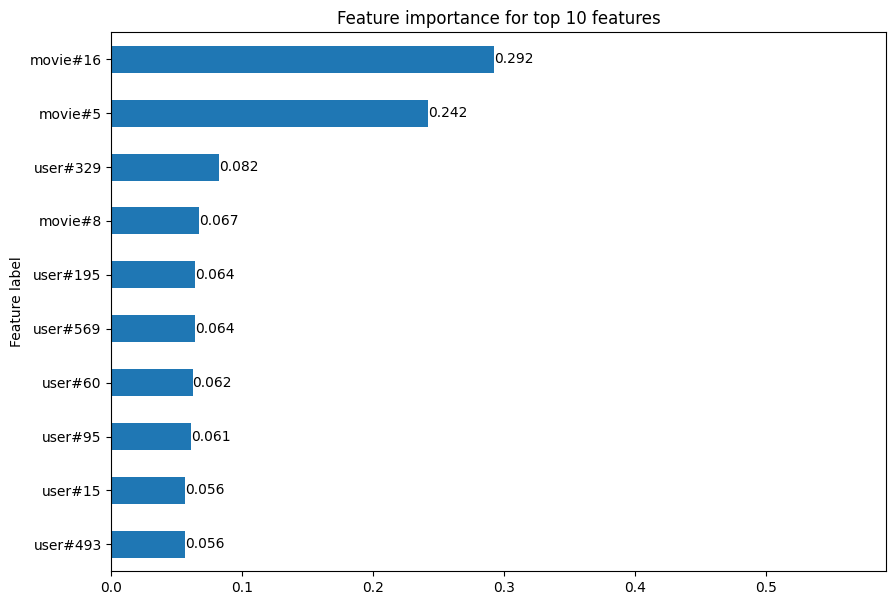

In [19]:
explanation.visualize_feature_importance(top_k=10)

## Plotting explanation graph
The explanation graph eliminates nodes and edges that do not contribute to our prediction, retaining only the edges that have a meaningful impact.

User:411 ----rates----> 915
Graph being created
Graph created


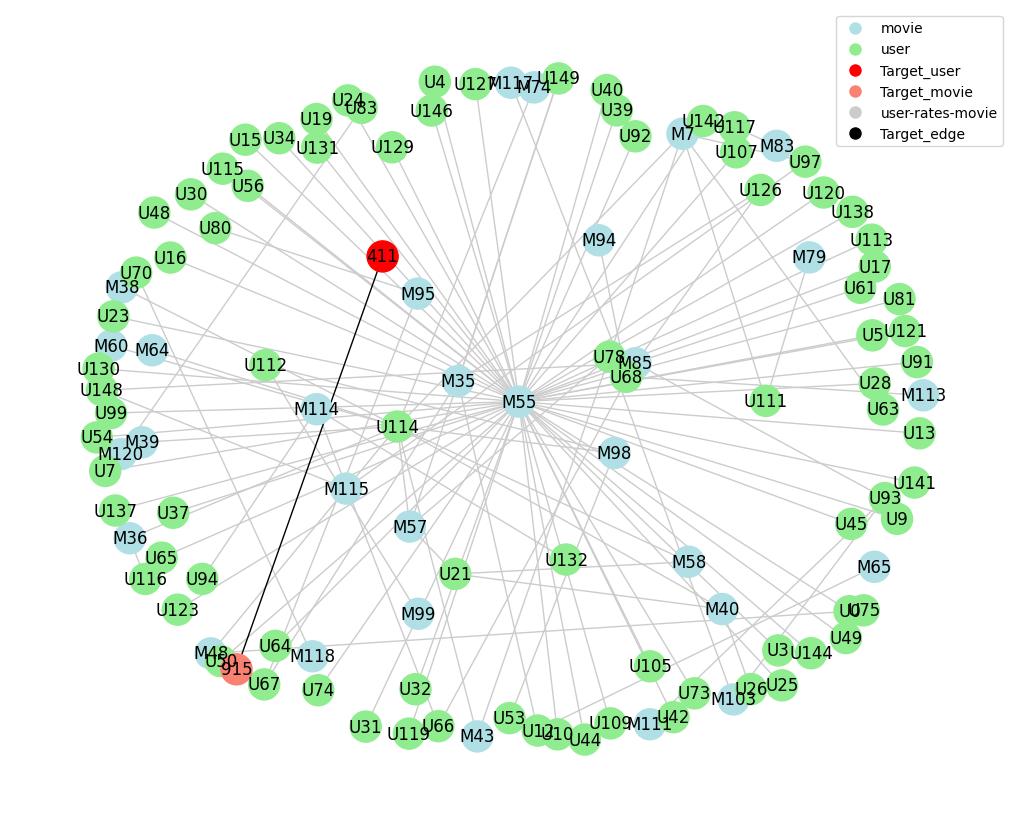

In [20]:
from utils import target_graph_plot
# plotting a explanation subgraph
# Returns the induced subgraph, in which all nodes and edges with zero attribution are masked out.
g  = explanation.get_explanation_subgraph()
target_graph_plot(index[0], g, train_data)

In [21]:
# Plotting graph, with edges with 0 contribution are removed.

edgesu = []
edgesm = []

for i in range(len(explanation["user", "rates", "movie"]["edge_mask"])):
    if explanation["user", "rates", "movie"]["edge_mask"][i] != 0:
        edgesu.append(int(explanation["user", "rates", "movie"]["edge_index"][0][i]))
        edgesm.append(int(explanation["user", "rates", "movie"]["edge_index"][1][i]))
        


In [22]:
edges = torch.stack([torch.tensor(edgesu), torch.tensor(edgesm)], dim = 0)

In [23]:
masked_graph = HeteroData()
masked_graph['user', 'rates', 'movie'].edge_index = edges

## Plotting unmasked edges

User:411 ----rates----> 915
Graph being created
Graph created


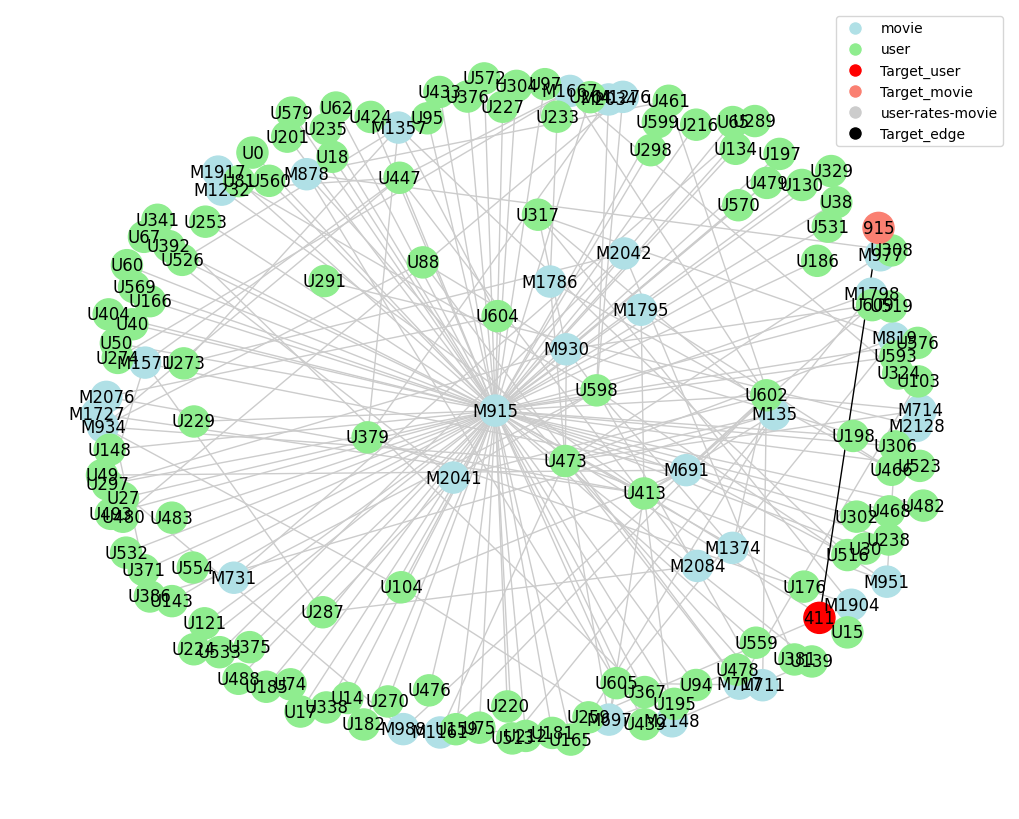

In [24]:
target_graph_plot(index[0], masked_graph, train_data)